In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences

from metric_utils import plot_training_history

print(tf.__version__)
tf.random.set_seed(3004)

2.17.0


In [2]:
def compute_tm_score(y_true, y_pred):
    L_ref = y_true.shape[0]

    # Correcto manejo de d0 según la definición
    if L_ref >= 30:
        d0 = 0.6 * np.sqrt(L_ref - 0.5) - 2.5
    elif L_ref < 12:
        d0 = 0.3
    elif 12 <= L_ref <= 15:
        d0 = 0.4
    elif 16 <= L_ref <= 19:
        d0 = 0.5
    elif 20 <= L_ref <= 23:
        d0 = 0.6
    elif 24 <= L_ref <= 29:
        d0 = 0.7

    distances = np.linalg.norm(y_true - y_pred, axis=1)

    tm_score = (1 / L_ref) * np.sum(1 / (1 + (distances / d0) ** 2))

    return tm_score

class TMScoreLogger(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train, verbose=0)
        y_val_pred = self.model.predict(self.X_val, verbose=0)

        train_score = compute_tm_score(self.y_train, y_train_pred)
        val_score = compute_tm_score(self.y_val, y_val_pred)

        tm_train_scores.append(train_score)
        tm_val_scores.append(val_score)

        print(f"Epoch {epoch + 1} — TM-score Train: {train_score:.4f}, Val: {val_score:.4f}")

In [3]:
#Crear rutas
train_data_path = os.path.join('..', 'data', 'labeled', 'train_labeled.csv')
val_data_path = os.path.join('..', 'data', 'labeled', 'val_labeled.csv')

#Cargar datos
df_train = pd.read_csv(train_data_path)
df_train = df_train.rename(columns={'entropy_log':'log_entropy'})

df_val = pd.read_csv(val_data_path)

df_train = df_train[~((df_train['x_1'] == -1e18) | 
                      (df_train['y_1'] == -1e18) | 
                      (df_train['z_1'] == -1e18))]

# Si deseas aplicar lo mismo a df_val
df_val = df_val[~((df_val['x_1'] == -1e18) | 
                  (df_val['y_1'] == -1e18) | 
                  (df_val['z_1'] == -1e18))]

#Definir columnas
feature_cols = [
    'A', 'C', 'G', 'U',
    'relative_position', 'log_entropy'
]
target_cols = ['x_1', 'y_1', 'z_1']

df_train = df_train.dropna(subset=target_cols).reset_index(drop=True)

#Splits
X_train = df_train[feature_cols].values.astype(np.float32)
y_train = df_train[target_cols].values.astype(np.float32)

X_val = df_val[feature_cols].values.astype(np.float32)
y_val = df_val[target_cols].values.astype(np.float32)

#Meta 
train_meta = df_train[['sequence_id', 'position']].reset_index(drop=True)
val_meta = df_val[['sequence_id', 'position']].reset_index(drop=True)

#Callback
tm_callback = TMScoreLogger(
    X_train, y_train,
    X_val, y_val
)

In [4]:
df_train.head()

,sequence_id,position,nucleotide,relative_position,A,C,G,U,entropy,log_entropy,x_1,y_1,z_1
0,1SCL_A,0,G,0.000000,False,False,True,False,1.640143,0.970833,13.760,-25.974001,0.102
1,1SCL_A,1,G,0.035714,False,False,True,False,1.901783,1.065325,9.310,-29.638000,2.669
2,1SCL_A,2,G,0.071429,False,False,True,False,1.796112,1.028230,5.529,-27.813000,5.878
3,1SCL_A,3,U,0.107143,False,False,False,True,1.837590,1.042955,2.678,-24.900999,9.793
4,1SCL_A,4,G,0.142857,False,False,True,False,1.840663,1.044038,1.827,-20.136000,11.793


In [5]:
def build_model(input_dim=6):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.2),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Dense(3)  # Predicción de x, y, z
    ])
    return model

In [6]:
model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

In [7]:
tm_train_scores = []
tm_val_scores = [] 

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
              tm_callback]
)

Epoch 1/100
1019/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22131.9238 - mae: 108.9412 - mse: 22131.9238Epoch 1 — TM-score Train: 0.6152, Val: 0.0734
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 22119.9043 - mae: 108.9180 - mse: 22119.9043 - val_loss: 9259.8828 - val_mae: 85.3392 - val_mse: 9259.8828
Epoch 2/100
 992/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16430.4414 - mae: 99.9743 - mse: 16430.4414Epoch 2 — TM-score Train: 0.6087, Val: 0.0734
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 16425.6582 - mae: 99.9742 - mse: 16425.6582 - val_loss: 8678.2246 - val_mae: 82.6431 - val_mse: 8678.2246
Epoch 3/100
1000/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16373.7617 - mae: 100.2247 - mse: 16373.7617Epoch 3 — TM-score Train: 0.6099, Val: 0.0716
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 16370.8965 - mae: 100.2217 - mse: 16370.8965 - val_loss: 8873.0439 - val_mae: 83.5518 - val_mse: 8873.0439
Epoch 4/100
1010/1023 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16358.

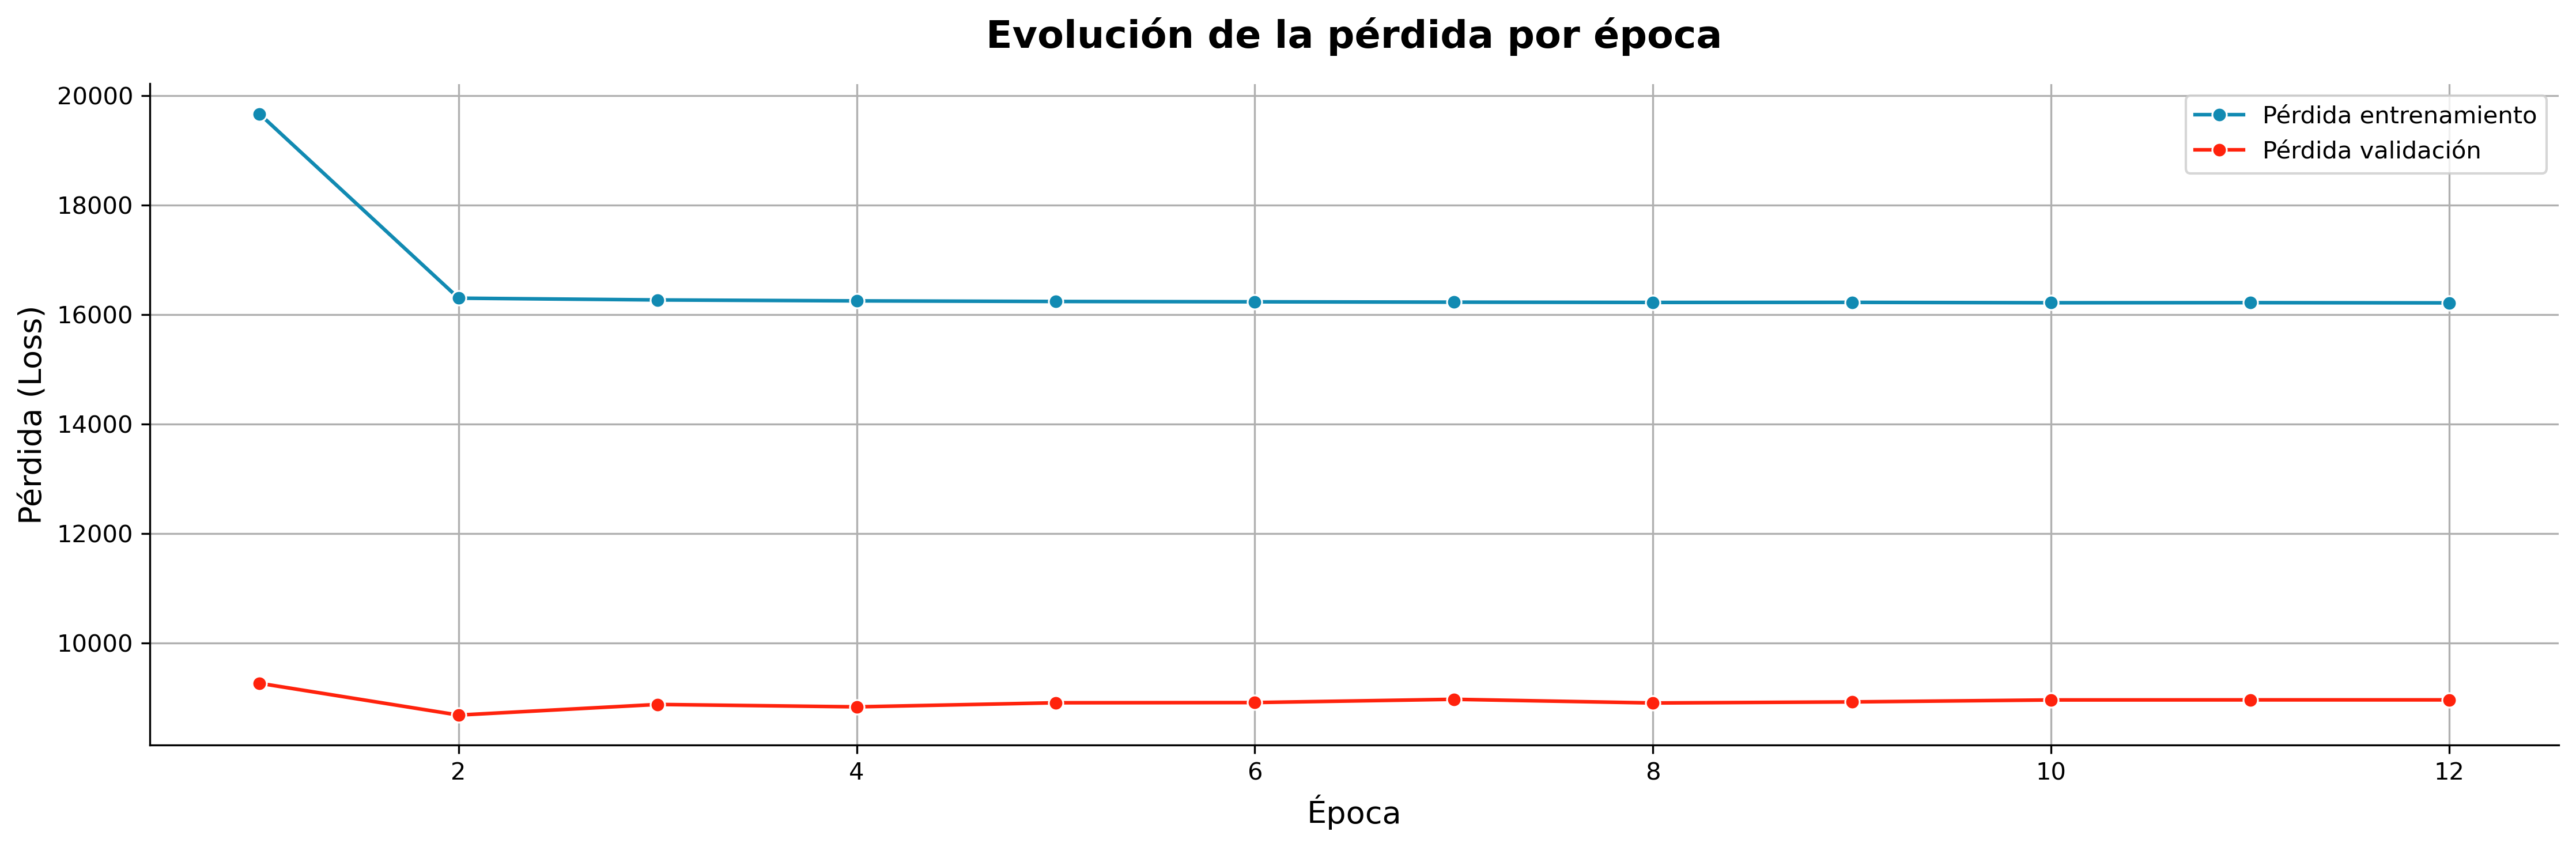

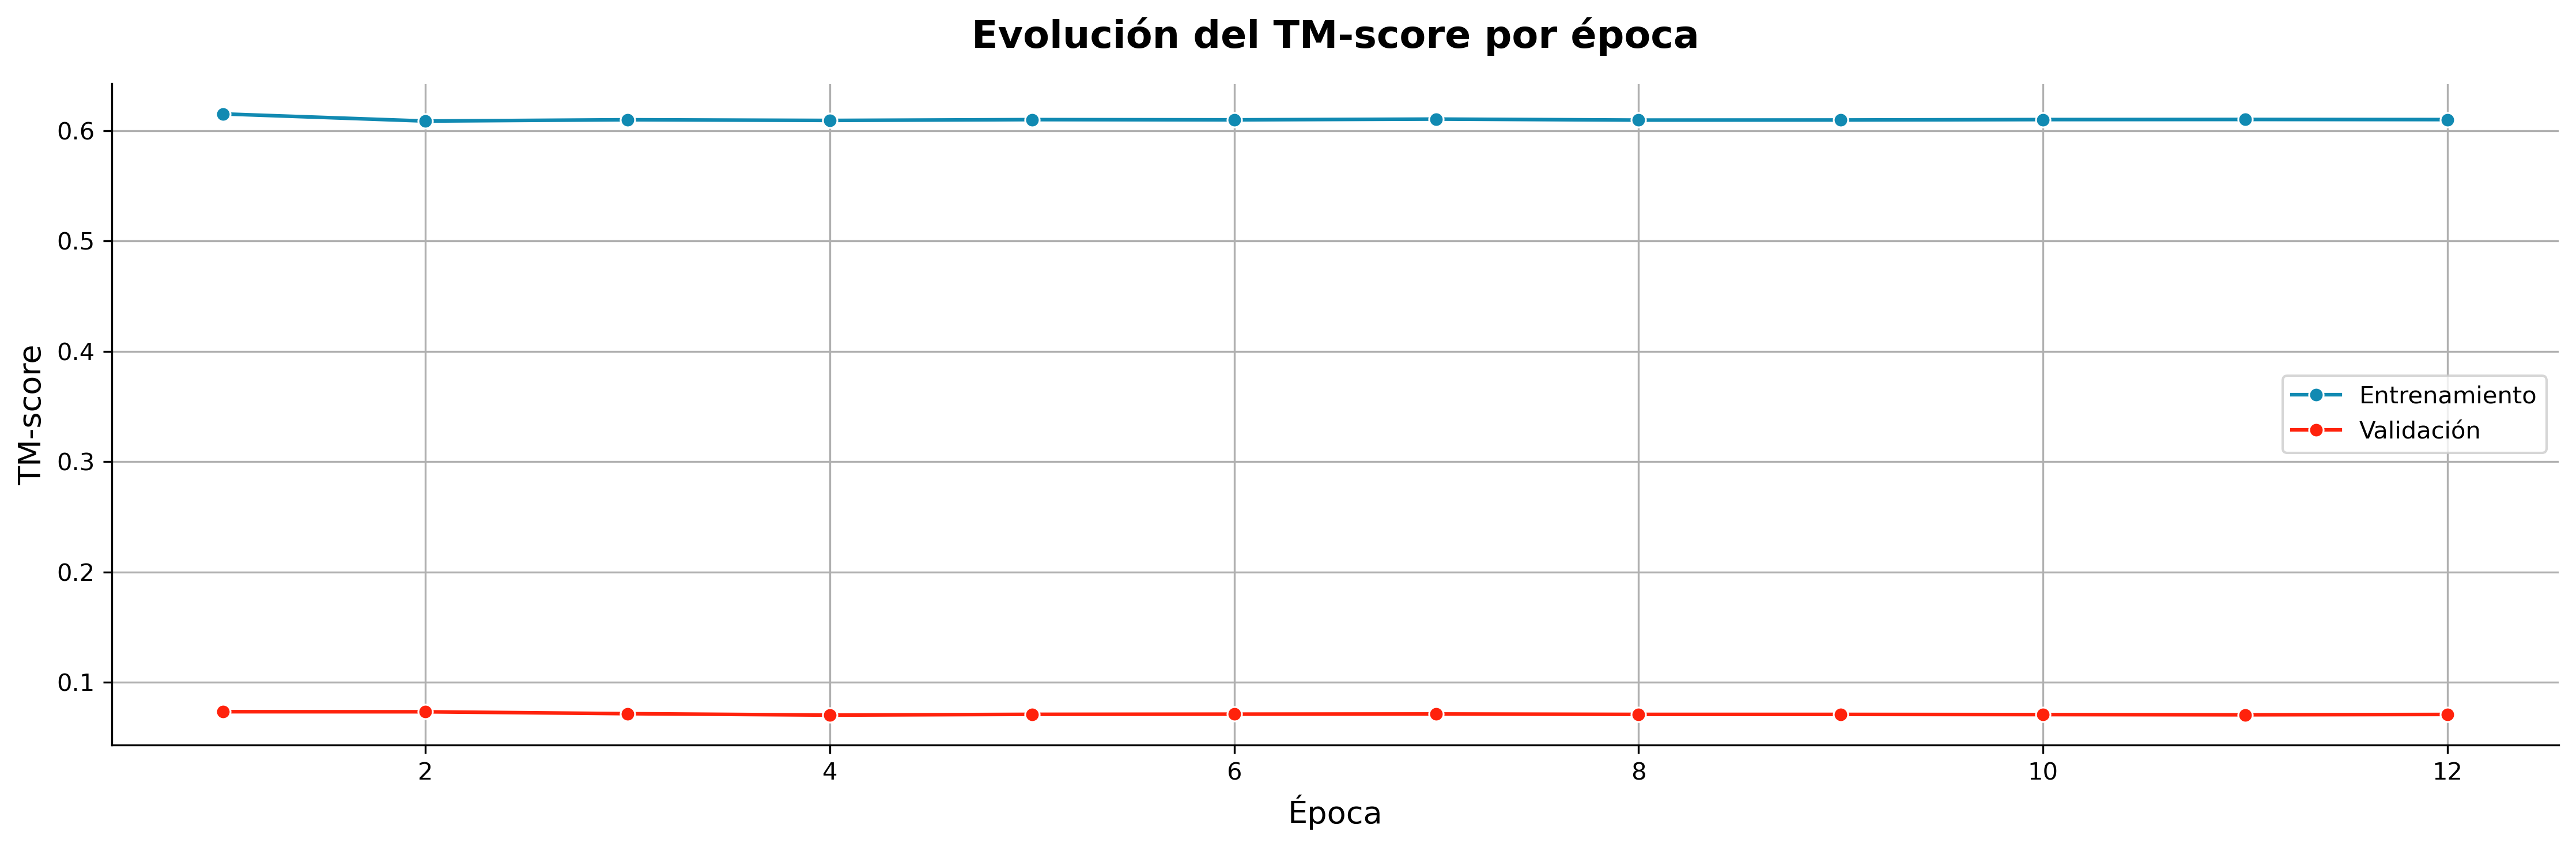

In [8]:
plot_training_history(history, train_tm_score= tm_train_scores, val_tm_score= tm_val_scores)

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,411 (900.05 KB)

 Trainable params: 76,419 (298.51 KB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 152,840 (597.04 KB)

### Experimento con RNN

In [5]:
def create_sequences(df, feature_cols, target_cols):
    X, y = [], []
    ids = df['sequence_id'].unique()
    
    for seq_id in ids:
        seq_data = df[df['sequence_id'] == seq_id]
        X.append(seq_data[feature_cols].values)
        y.append(seq_data[target_cols].values)
        
    return X, y

In [14]:
X_train, y_train = create_sequences(df_train, feature_cols, target_cols)
X_val, y_val = create_sequences(df_val, feature_cols, target_cols)

# Padding
X_train_padded = pad_sequences(X_train, padding='post', dtype='float32')
y_train_padded = pad_sequences(y_train, padding='post', dtype='float32')

X_val_padded = pad_sequences(X_val, padding='post', dtype='float32')
y_val_padded = pad_sequences(y_val, padding='post', dtype='float32')

# Crear máscaras (útiles para pérdida)
train_mask = np.any(X_train_padded != 0, axis=-1)
val_mask = np.any(X_val_padded != 0, axis=-1)

In [15]:
def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    mask = layers.Masking(mask_value=0.0)(inputs)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(mask)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)
    outputs = layers.TimeDistributed(layers.Dense(3))(x)
    
    model = models.Model(inputs, outputs)
    return model

input_shape = X_train_padded.shape[1:]
model = build_model(input_shape)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 4269, 6)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 4269, 6)   │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 4269, 6)   │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_3 (Any)         │ (None, 4269)      │          0 │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 4269, 256) │    138,240 │ masking_3[0][0],  │
│ (Bidirectional)     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 4269, 128) │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 4269, 64)  │      8,256 │ bidirectional_1[… │
│ (TimeDistributed)   │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 4269, 3)   │        195 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ any_3[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,043 (1.19 MB)

 Trainable params: 311,043 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
tm_train_scores = []
tm_val_scores = [] 

history = model.fit(
    X_train_padded, y_train_padded,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_padded, y_val_padded),
    callbacks= [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), 
              tm_callback]
)

Epoch 1/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2436.2673 - mae: 14.7309

ValueError: Input 0 of layer "functional_5" is incompatible with the layer: expected shape=(None, 500, 6), found shape=(32, 6)